# Quantum Variable Rotation

Quantum variable rotation (QVR) represents a family of Bloqs that can act as a Phase Oracle[1, 2],
i.e. it implements a unitary which phases each computational basis state $|x\rangle$, on which
the wave-function has support, by an amount $e^{i 2\pi \gamma x}$. The general unitary can be
defined as

$$
\text{QVR}_{n, \epsilon}(\gamma)\sum_{j=0}^{2^n-1} c_j|x_j\rangle\rightarrow\sum_{j=0}^{2^n-1}
e^{2\pi i\widetilde{\gamma x_j}}c_j|x_j\rangle
$$

where $\epsilon$ parameterizes the accuracy to which we wish to synthesize the phase
coefficients s.t.

$$
|e^{2\pi i\widetilde{\gamma x_j}} - e^{2\pi i \gamma x_j}| \leq \epsilon
$$

which, using rules of propagation of error [3], implies

$$
|\gamma x_j - \widetilde{\gamma x_j}| \leq \frac{\epsilon}{2\pi}
$$

The linked references typically assume that $0 \leq x_{j} \le 1$ and $-1 \leq \gamma \leq 1$,
for ease of exposition and analysis, but we do not have any such constraint. In the
implementations presented below, both the cost register $|x\rangle$ and $\gamma$ can be
arbitrary fixed point integer types.
Each section below presents more details about the constraints on cost register
$|x\rangle$ and scaling constant $\gamma$.


References:
  1. [Faster quantum chemistry simulation on fault-tolerant quantum
        computers](https://iopscience.iop.org/article/10.1088/1367-2630/14/11/115023/meta)
        Fig 14.
  2. [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial
        Optimization](https://arxiv.org/abs/2007.07391) Appendix C: Oracles for
        phasing by cost function
  3. [Formulae for propagating
        uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae)

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `QvrZPow`
QVR oracle that applies a ZPow rotation to every qubit in the n-bit cost register.

This phase oracle simply applies a $Z^{2^{k}}$ rotation to every qubit in the cost register.
To obtain a desired accuracy of $\epsilon$, each individual rotation is synthesized with accuracy
$\frac{\epsilon}{n}$, where $n$ is the size of cost register.

The toffoli cost of this method scales as

$$
    \text{Toffoli Cost} \approxeq \mathcal{O}\left(n \log{\frac{n}{\epsilon}} \right)
$$

#### Parameters
 - `cost_reg`: Cost register of dtype `QFxp`. Supports arbitrary `QFxp` types, including signed and unsigned.
 - `gamma`: Scaling factor to multiply the cost register by, before applying the phase. Can be arbitrary floating point number.
 - `eps`: Precision for synthesizing the phases.


In [2]:
from qualtran.bloqs.rotations.quantum_variable_rotation import QvrZPow

### Example Instances

In [3]:
qvr_zpow = QvrZPow.from_bitsize(12)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([qvr_zpow],
           ['`qvr_zpow`'])

### Call Graph

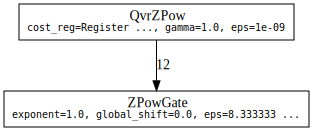

#### Counts totals:
 - `Z`: 12

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
qvr_zpow_g, qvr_zpow_sigma = qvr_zpow.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(qvr_zpow_g)
show_counts_sigma(qvr_zpow_sigma)

## `QvrPhaseGradient`
QVR oracle that applies a rotation via addition into the phase gradient register.

A $b_\text{grad}$-bit phase gradient state $|\phi\rangle_{b_\text{grad}}$ can be written as

$$
    |\phi\rangle_{b_\text{grad}} = \frac{1}{\sqrt{2^{b_\text{grad}}}}
    \sum_{k=0}^{2^{b_\text{grad}} - 1} e^{\frac{-2\pi i k}{2^{b_\text{grad}}}}
    \ket{\frac{k}{2^{b_\text{grad}}}}
$$

In the above equation $\frac{k}{2^{b_\text{grad}}}$ represents a fixed point fraction. In
Qualtran, we can represent such a quantum register using quantum data type
`QFxp(bitsize=b_grad, num_frac=b_grad, signed=False)`. Let
$\tilde{k}=\frac{k}{2^{b_\text{grad}}}$ be a $b_\text{grad}$-bit fixed point fraction,
we can rewrite the phase gradient state as


$$
    |\phi\rangle_{b_\text{grad}} = \frac{1}{\sqrt{2^{b_\text{grad}}}}
    \sum_{\tilde{k}=0}^{\frac{2^{b_\text{grad}-1}}{2^{b_\text{grad}}}}
    e^{-2\pi i \tilde{k}} \ket{\tilde{k}}
$$


A useful property of the phase gradient state is that adding a fixed-point number
$\tilde{l}$ to the state applies a phase-kickback of $e^{2\pi i \tilde{l}}$

$$
|\phi + \tilde{l}\rangle_{b_\text{grad}} = e^{2\pi i \tilde{l}}|\phi\rangle_{b_\text{grad}}
$$

We exploit this property of the phase gradient states to implement a quantum variable
rotation via addition into the phase gradient state s.t.

$$\begin{aligned}
    \text{QVR}_{n,\epsilon}(\gamma)|x\rangle|\phi\rangle &=|x\rangle|\phi+\gamma x\rangle \\
                                      &= e^{2\pi i \gamma x}|x\rangle |\phi\rangle
\end{aligned}$$

A number of subtleties arise as part of this procedure and we describe them below one by one.

- **Adding a scaled value into phase gradient register** Instead of computing $\gamma x$ an
    intermediate register, we perform the multiplication via repeated additions into the phase
    gradient register, as described in [2]. This requires us to represent $\gamma$ as a fixed
    point fraction with bitsize $\gamma_\text{bitsize}$. This procedure introduces two sources
    of errors:
    - **Errors due to fixed point representation of $\gamma$** - Note that adding any fixed
        point number of the form $a.b$ to the phase gradient register is equivalent to adding
        $0.b$ since $e^{2\pi i a} = 1$ for every integer $a$. Let $\tilde{\gamma} = a.b$ and
        $x = p.q$ be fixed point decimal representations of $\gamma$ and $x$. We can write
        the product $\gamma x$ as
    $$
          \tilde{\gamma} x = (\sum_{i=0}^{\gamma_\text{n\_int}} a_{i} * 2^{i} +
          \sum_{i=1}^{\gamma_\text{n\_frac}} \frac{b_i}{2^i}) (\sum_{j=0}^{x_\text{n\_int}}
          p_{j} * 2^{j} + \sum_{j=1}^{x_\text{n\_frac}} \frac{q_{j}}{2^{j}})
    $$
    In order to compute $\tilde{\gamma} x$ to precision $\frac{\epsilon}{2\pi}$, we can
    ignore all terms in the above summation that are < $\frac{\epsilon}{2\pi}$.
    Let $b_\text{phase} = \log_2{\frac{2\pi}{\epsilon}}$, then we get
    $\gamma_\text{n\_frac} = x_\text{n\_int} + b_\text{phase}$. Thus,

    $$\begin{aligned}
          \gamma_\text{bitsize} &= \gamma_\text{n\_int} + x_\text{n\_int} + b_\text{phase} \\
                                &\approxeq \log_2{\frac{1}{\epsilon}} + x_\text{n\_int} + O(1)
    \end{aligned}$$

    - **Errors due to truncation of digits of $|x\rangle$ during multiplication via repeated
        addition** - Let $b_\text{grad}$ be the size of the phase gradient register. When
        adding left/right shifted copies of state $x$ to the phase gradient register, we incur
        an error every time the fractional part of the shifted state to be added needs to be
        truncated to $b_\text{grad}$ digits. For each such addition the error is upper bounded
        by $\frac{2\pi}{2^{b_\text{grad}}}$, because we omit adding bits that would correspond
        to phase shifts of $\frac{2\pi}{2^{b_\text{grad}+1}}$, $\frac{2\pi}{2^{b_\text{grad}+2}}$,
        and so forth. The number of such additions can be upper bounded by
        $\frac{(\gamma_\text{bitsize} + 2)}{2}$ using techniques from [2].

      - **When $b_\text{grad} \geq x_\text{bitsize}$**:  the first $x_\text{n\_int}$ additions
        do not contribute to any phase error and thus the number of error causing additions can
        be upper bounded by $\frac{(b_\text{phase} + 2)}{2}$. In order to keep the error less
        than $\epsilon$, we get
        $$\begin{aligned}
        b_\text{grad}&=\left\lceil\log_2{\frac{\text{num\_additions}\times2\pi}{\epsilon}}
                    \right\rceil \\
                    &=\left\lceil\log_2{\frac{(b_\text{phase}+2)\pi}{\epsilon}}\right\rceil
                    \text{; if }
                    b_\text{grad} \geq x_\text{bitsize}  \\
        \end{aligned}$$
      - **When $b_\text{grad} \lt x_\text{bitsize}$**: We believe that the above precision for
        $b_\text{grad}$ holds even for this case we have some numerics in tests to verify that.
        Currently, `QvrPhaseGradient` always sets the bitsize of phase gradient register as per
        the above equation.

- **Constraints on $\gamma$ and $|x\rangle$** - In the current implementation, $\gamma$ can be
    any arbitrary floating point number (signed or unsigned) and $|x\rangle$ must be an unsigned
    fixed point register.

- **Cost of the phase gradient procedure** - Each addition into the phase gradient register
    costs $b_\text{grad} - 2$ Toffoli's and there are $\frac{\gamma_\text{bitsize} + 2}{2}$
    such additions, therefore the total Toffoli cost is

    $$\begin{aligned}
        \text{Toffoli Cost} &= \frac{(b_\text{grad} - 2)(\gamma_\text{bitsize} + 2)}{2} \\
    \end{aligned}$$


Thus, for cases where $-1\lt \gamma \lt 1$ and $0 \leq x \lt 1$, the toffoli cost scales
as $\mathcal{O}\left(\log^2{\frac{1}{\epsilon}} \log{\log{\frac{1}{\epsilon}}}\right)$

#### References
 - [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391). Section II-C: Oracles for phasing by cost function. Appendix A: Addition for controlled rotations


In [6]:
from qualtran.bloqs.rotations.quantum_variable_rotation import QvrPhaseGradient

### Example Instances

In [7]:
qvr_phase_gradient = QvrPhaseGradient.from_bitsize(12)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([qvr_phase_gradient],
           ['`qvr_phase_gradient`'])

### Call Graph

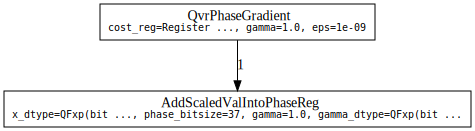

#### Counts totals:
 - `AddScaledValIntoPhaseReg(x_dtype=QFxp(bitsize=12, num_frac=12, signed=False), phase_bitsize=37, gamma=1.0, gamma_dtype=QFxp(bitsize=33, num_frac=33, signed=False))`: 1

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
qvr_phase_gradient_g, qvr_phase_gradient_sigma = qvr_phase_gradient.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(qvr_phase_gradient_g)
show_counts_sigma(qvr_phase_gradient_sigma)

## QVR Cost analysis
### T-Count Expression for `QvrZpow`

In [10]:
from qualtran.resource_counting.t_counts_from_sigma import t_counts_from_sigma

def get_t_counts_qvr_zpow(n, gamma, eps):
    _, sigma = QvrZPow.from_bitsize(n, gamma, eps).call_graph()
    return t_counts_from_sigma(sigma)


get_t_counts_qvr_zpow(*sympy.symbols('n, \gamma, \epsilon'))

n*ceiling(1.149*log2(1.0*n/\epsilon) + 9.2)

### T-Count Expression for `QvrPhaseGradient`

In [11]:
def get_t_counts_qvr_phase_gradient(n, gamma, eps):
    _, sigma = QvrPhaseGradient.from_bitsize(n, gamma, eps).call_graph()
    return t_counts_from_sigma(sigma)


get_t_counts_qvr_phase_gradient(*sympy.symbols('n, \gamma, \epsilon'))

(4*ceiling(log2(pi*(2*floor(ceiling(log2(2*pi/\epsilon))/2) + 2)/\epsilon)) - 8)*(floor(ceiling(log2(2*pi/\epsilon))/2 + Max(0, ceiling(log2(Abs(\gamma))))/2) + 1)

### T-Counts($\epsilon$) assuming $n=\log_2(\frac{2\pi}{\epsilon})$ and various fixed values of $\gamma$

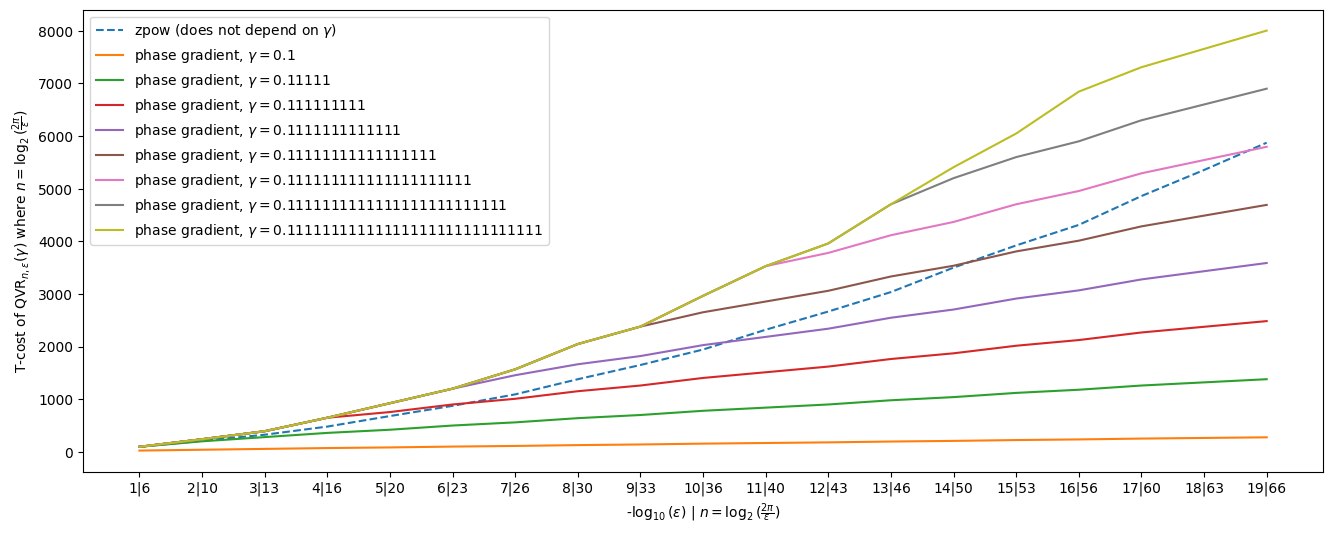

In [12]:
import matplotlib.pyplot as plt

num_eps = 20
eps_vals = [1/10**i for i in range(1, num_eps)]
n_vals = [int(np.ceil(np.log2(2 * np.pi / eps))) for eps in eps_vals]

x_vals = [i for i in range(1, num_eps)]
zpow_vals = [get_t_counts_qvr_zpow(n, sympy.Symbol('\gamma'), eps) for n, eps in zip(n_vals, eps_vals)]

num_gamma = 18
pg = []
gamma_ones = [i for i in range(1, 30, 4)]
for n_ones in gamma_ones:
    gamma = (2**n_ones - 1)/2**n_ones
    pg.append([get_t_counts_qvr_phase_gradient(n, gamma, eps) for n, eps in zip(n_vals, eps_vals)])


plt.figure(figsize=(16,6))
plt.plot(x_vals, zpow_vals, label=r'zpow (does not depend on $\gamma$)', linestyle='--')
for i, n_ones in enumerate(gamma_ones):
    plt.plot(x_vals, pg[i], label=f'phase gradient, $\gamma=0.{"1"*n_ones}$')

x_labels = [f'{x}|{n}' for x, n in  zip(x_vals, n_vals)]
plt.xticks(ticks=x_vals, labels=x_labels)
plt.ylabel(r'T-cost of $\text{QVR}_{n, \epsilon}(\gamma)$ where $n=\log_2(\frac{2\pi}{\epsilon})$')
plt.xlabel(r'-$\log_{10}(\epsilon)$ | $n=\log_2(\frac{2\pi}{\epsilon})$')
plt.legend()

### T-Counts($n$) assuming a fixed $\epsilon = 10^{-12}$ and various fixed values of $\gamma$

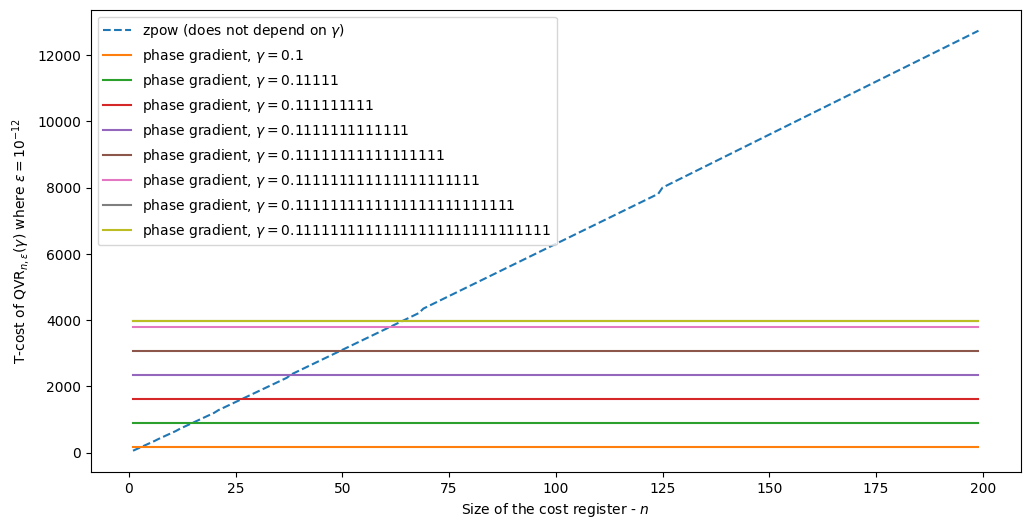

In [13]:
import matplotlib.pyplot as plt

eps = 1e-12
n_vals = [*range(1, 200)]

zpow_vals = [get_t_counts_qvr_zpow(n, sympy.Symbol('\gamma'), eps) for n in n_vals]

pg = []
for n_ones in gamma_ones:
    gamma = (2**n_ones - 1)/2**n_ones
    pg.append([get_t_counts_qvr_phase_gradient(n, gamma, eps) for n in n_vals])

plt.figure(figsize=(12,6))

x_vals = [n for n in n_vals]
plt.plot(x_vals, zpow_vals, label=r'zpow (does not depend on $\gamma$)', linestyle='--')
for i, n_ones in enumerate(gamma_ones):
    plt.plot(x_vals, pg[i], label=f'phase gradient, $\gamma=0.{"1"*n_ones}$')
plt.ylabel(r'T-cost of $\text{QVR}_{n, \epsilon}(\gamma)$ where $\epsilon=10^{-12}$')
plt.xlabel(r'Size of the cost register - $n$')
plt.legend()